In [1]:
import pandas as pd

In [2]:
data = pd.read_csv(r'C:\users\shand\Downloads\archive\star_classification.csv')

In [3]:
print(data.columns)

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')


In [5]:
print(data.isnull().sum())

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [8]:
data['u_g'] = data['u'] - data['g']
data['g_r'] = data['g'] - data['r']
data['r_i'] = data['r'] - data['i']
data['i_z'] = data['i'] - data['z']

In [9]:
features = ['u_g', 'g_r', 'r_i', 'i_z']
X = data[features].fillna(data[features].mean())

In [10]:
y = LabelEncoder().fit_transform(data['class'])


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

Random Forest Accuracy: 0.863
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     11860
           1       0.79      0.78      0.79      3797
           2       0.81      0.73      0.77      4343

    accuracy                           0.86     20000
   macro avg       0.83      0.82      0.82     20000
weighted avg       0.86      0.86      0.86     20000

SVM Accuracy: 0.824
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     11860
           1       0.79      0.68      0.73      3797
           2       0.73      0.64      0.68      4343

    accuracy                           0.82     20000
   macro avg       0.79      0.75      0.77     20000
weighted avg       0.82      0.82      0.82     20000



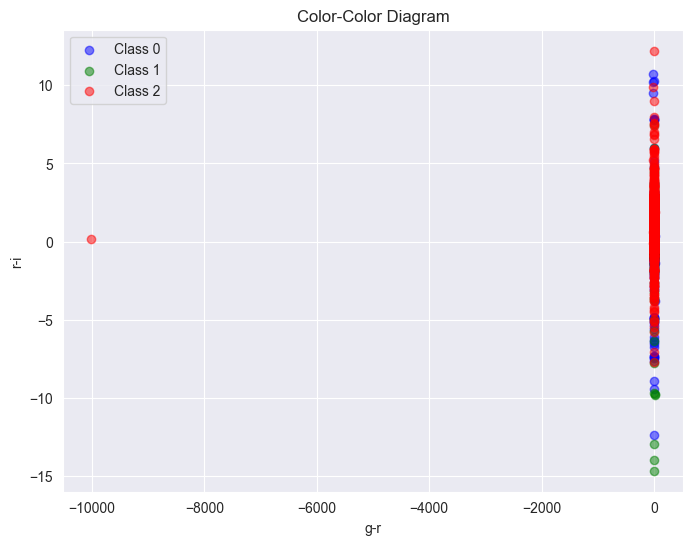

In [14]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', C=10, gamma=0.1)
}


for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred))

plt.figure(figsize=(8,6))
for obj_class, color in zip([0,1,2], ['blue','green','red']):
    mask = y == obj_class
    plt.scatter(X['g_r'][mask], X['r_i'][mask], alpha=0.5, c=color, label=f'Class {obj_class}')
plt.xlabel('g-r')
plt.ylabel('r-i')
plt.title('Color-Color Diagram')
plt.legend()
plt.show()


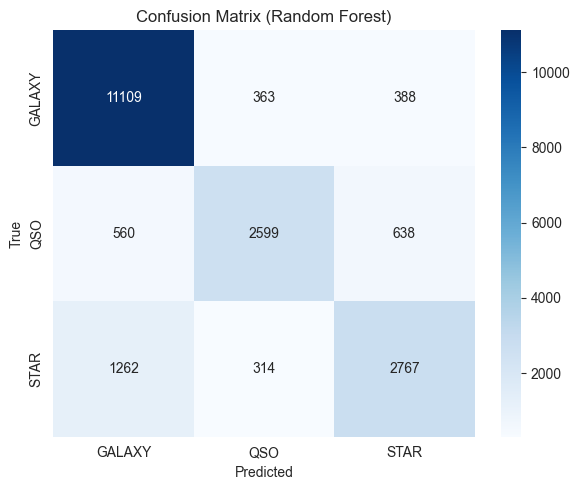

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Make sure LabelEncoder is defined and fitted on your target
le = LabelEncoder()
y_encoded = le.fit_transform(data['class'])  # fit on your full target
# If you already have y_test and y_pred, you can skip re-encoding

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Random Forest)")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


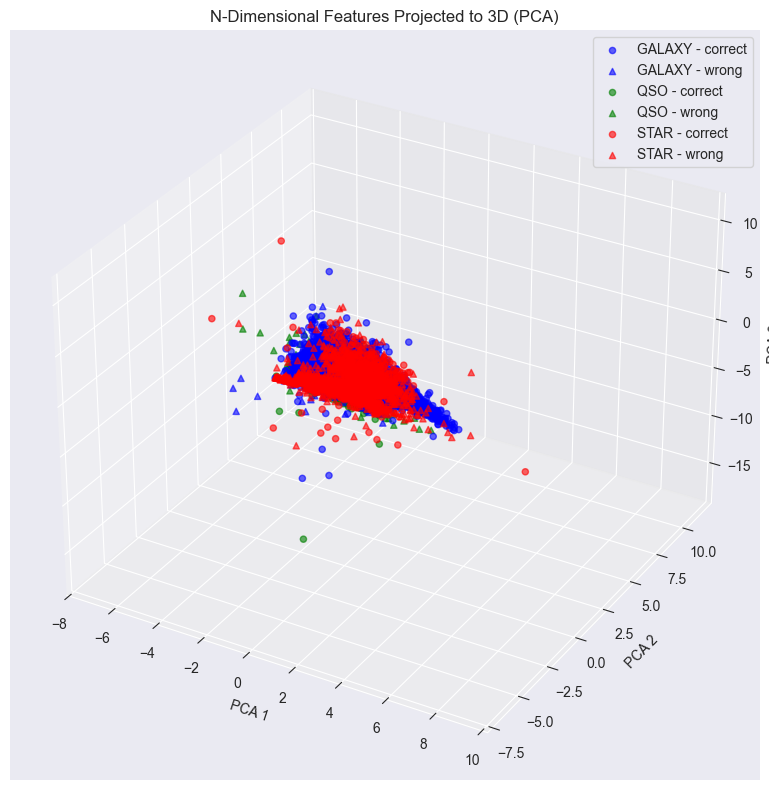

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Select all features (color indices)
X_all = X_test  # X_test already contains color indices
y_true = y_test
y_pred_labels = y_pred

# Apply PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_all)

# Colors and markers for plotting
colors = ['blue','green','red']  # one for each class
markers = ['o', '^']  # o = correct, ^ = incorrect

# Determine correctness
correct = (y_true == y_pred_labels)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

for class_idx, color in enumerate(colors):
    for is_correct, marker in zip([True, False], markers):
        mask = (y_true == class_idx) & (correct == is_correct)
        ax.scatter(X_pca[mask,0], X_pca[mask,1], X_pca[mask,2],
                   c=color, marker=marker, alpha=0.6,
                   label=f"{le.classes_[class_idx]} - {'correct' if is_correct else 'wrong'}")

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('N-Dimensional Features Projected to 3D (PCA)')

# Create legend without duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=10)

plt.tight_layout()
plt.savefig("N_dimensional_classification.png")
plt.show()
